In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"    8577872
import tensorflow as tf

import PIL
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from circle_fit import hyper_fit
from skimage.draw import line
from skimage.transform import resize
from skimage.measure import subdivide_polygon
from cv2 import equalizeHist, createCLAHE
import random
import math
import pickle
Image.MAX_IMAGE_PIXELS = 1000000000

from keras.models import load_model

Using TensorFlow backend.


In [2]:
from rim_finder import build_model

model = build_model(weightpath='./models/thin_weights.h5')
#model = load_model('./models/thin_overfit.h5')

In [4]:
from load_data import load_craters, Rim, make_channels

rims = load_craters()

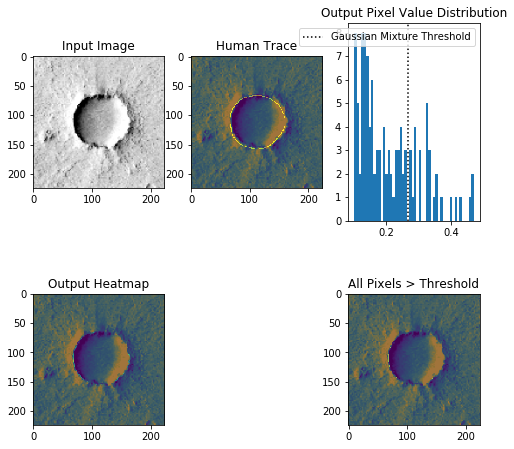

In [5]:
from sklearn.mixture import GaussianMixture

def get_pred(rim, model):
    X, Y = rim.draw_rim(crop_off=.3)
    X = np.expand_dims(make_channels(X), axis=0)/255
    Y = np.expand_dims(Y, axis=0)/255
    Y_pred = model.predict(X)
    return X[0, :, :, 0], Y[0], Y_pred[0]

def plot_distro(rim, model, rescale=1, disp=(0, 0)):
    #X, Y = prepare_image(rim, rescale=rescale, disp=disp)
    #img = X[0, :, :, 0]
    #Y_pred = model.predict(X)[0]
    img, Y, Y_pred = get_pred(rim, model)
    flat = Y_pred.flatten()
    values = flat[np.argwhere(flat > .1)][:, 0]
    fig, ax_ = plt.subplots(2, 3, figsize=(8, 8));
    ax = ax_[0]
    gmm = GaussianMixture(n_components=2)
    gmm.fit(values.reshape(-1, 1))
    pred = gmm.predict(values.reshape(-1, 1))
    c0 = values[np.argwhere(pred==0)]
    c1 = values[np.argwhere(pred==1)]
    top_group = max(c0.mean(), c1.mean())
    if top_group == c0.mean():
        bum_group = c1
    else:
        bum_group = c0
    threshold = max(gmm.means_)
    #threshold = bum_group.max()
    ax[1].imshow(img)
    ax[1].imshow(Y, alpha=.5)
    ax[1].set_title('Human Trace')
    ax[2].hist(values, bins=50);
    ax[2].axvline(x=threshold, linestyle='dotted', color='black', label='Gaussian Mixture Threshold')
    ax[2].legend();
    ax[2].set_title('Output Pixel Value Distribution');
    ax[0].imshow(img, cmap='Greys_r');
    ax[0].set_title('Input Image')
    ax = ax_[1]
    ax[0].imshow(img)
    ax[0].imshow(Y_pred, alpha=.5)
    ax[0].set_title('Output Heatmap')
    ax[1].remove()
    ax[2].imshow(img)
    ax[2].imshow(np.where(Y_pred > threshold, 1, 0), alpha=.5)
    ax[2].set_title('All Pixels > Threshold')
    plt.show()
    
plot_distro(rims[6], model)

In [4]:
import tensorflow as tf
from keras.layers import Input, BatchNormalization, Conv2D, Conv2DTranspose, Dense
from keras.layers import MaxPooling2D, Concatenate, Reshape, AveragePooling2D
from keras.layers import GaussianDropout
from keras.models import Model

def build_feature_model(weightpath='./models/thin_overfit.h5'):
    w = 8
    dim = 224
    weights = load_model(weightpath).get_weights()
    def conv_layer(n, w, weights=None):
        """Standard 3x3 conv layer used in model."""
        if weights is None:
            return Conv2D(filters=n*w, kernel_size=(3,3), padding='same', activation='relu')
        else:
            return Conv2D(filters=n*w, kernel_size=(3,3), padding='same', activation='relu', weights=weights)
    
    def deconv_layer(n, w, weights=None):
        """Standard 'deconvolution' layer used in model."""
        if weights is None:
            return Conv2DTranspose(filters=n*w, kernel_size=(2, 2), strides=2, activation='relu')
        else:
            return Conv2DTranspose(filters=n*w, kernel_size=(2, 2), strides=2, activation='relu', weights=weights)
    
    inp = Input((224, 224, 3))
    x = BatchNormalization(weights=weights[0:4])(inp)
    x = conv_layer(2, w, weights=weights[4:6])(x)
    x = conv_layer(4, w, weights=weights[6:8])(x)
    mid1 = BatchNormalization(weights=weights[8:12])(x)
    x = MaxPooling2D()(mid1)
    x = conv_layer(4, w, weights=weights[12:14])(x)
    x = conv_layer(8, w, weights=weights[14:16])(x)
    mid2 = BatchNormalization(weights=weights[16:20])(x)
    x = MaxPooling2D()(mid2)
    x = conv_layer(8, w, weights=weights[20:22])(x)
    x = conv_layer(16, w, weights=weights[22:24])(x)
    mid3 = BatchNormalization(weights=weights[24:28])(x)
    x = MaxPooling2D()(mid3)
    x = conv_layer(16, w, weights=weights[28:30])(x)
    x = conv_layer(32, w, weights=weights[30:32])(x)
    x = conv_layer(32, w, weights=weights[32:34])(x)
    mid4 = BatchNormalization(weights=weights[34:38])(x)
    x = MaxPooling2D()(mid4)
    x = conv_layer(32, w, weights=weights[38:40])(x)
    x = conv_layer(64, w, weights=weights[40:42])(x)
    mid5 = conv_layer(64, w, weights=weights[42:44])(x)
    x = Conv2D(filters=128*w, kernel_size=(1,1), padding='same', activation='relu', weights=weights[44:46])(mid5)
    x = AveragePooling2D(pool_size=(dim//16,dim//16))(x)
    x = Reshape((-1,))(x)
    x = Dense(128*w, activation='relu', weights=weights[46:48])(x)
    x = GaussianDropout(.05)(x, training=True)
    x = Dense(128*w, activation='relu', name='newdense1')(x)
    x = GaussianDropout(.05)(x, training=True)
    x = Dense(16*w, activation='relu', name='newdense2')(x)
    x = GaussianDropout(.05)(x, training=True)
    x = Dense(128*w, activation='relu', name='newdense3')(x)
    output = Dense(3, name='newdense4')(x)
    
    model = Model(inputs=inp, outputs=output)
    for layer in model.layers:
        if 'new' in layer.name:
            layer.trainable=True
        else:
            layer.trainable=False
    return model
    
model = build_feature_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 224, 224, 16)      448       
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 224, 224, 32)      4640      
_________________________________________________________________
batch_normalization_16 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 112, 112, 32)      9248      
__________

In [2]:
class Rim(object):
    def __init__(self, coordinates, img, mosaic=None):
        self.mosaic = mosaic
        self.cropped = None
        self.target = None
        self.top = img.size[1]
        self.edge = img.size[0]
        self.coords = []
        for coord in coordinates:
            coords = [float(x) for x in coord.split('\t')]
            coords[1] = self.top - coords[1]
            coords = tuple(coords)
            self.coords.append(coords)
        X0 = np.array([x[0] for x in self.coords])
        X1 = np.array([x[1] for x in self.coords])
        if any(X0 < 0) or any(X0 > self.edge):
            raise ValueError('Trace point outside image boundaries')
        if any(X1 < 0) or any(X1 > self.top):
            raise ValueError('Trace point outside image boundaries')
        prev_crd = self.coords[-1]
        self.d = []
        for i, crd in enumerate(self.coords):
            d = np.sqrt(np.sum(np.square(np.array(crd) - np.array(prev_crd))))
            self.d.append(d)
            prev_crd = crd
        self.min_0 = min([x[0] for x in self.coords])
        self.min_1 = min([x[1] for x in self.coords])
        self.fit_circle()
        self.create_footprint(img)
        
    def fit_circle(self, coords=None):
        """Fits a circle to the points on rim."""
        if coords is None:
            is_init = True
            coords = self.coords
        else:
            is_init = False
        xc, yc, R, residu = hyper_fit(coords)
        if is_init:
            self.c0 = xc
            self.c1 = yc
            self.r = R
            self.residual = residu
            self.res_ratio = self.residual/self.r
            return
        else:
            return xc, yc, R, residu
            
    def show(self):
        """Plots trace points in scatter plot."""
        arr = np.array(self.cropped)
        plt.figure(figsize=(10, 10))
        plt.imshow(arr, cmap='Greys_r');
        plt.scatter([z[1] for z in self.coords], [z[0] for z in self.coords])
        plt.show();
        
    def create_footprint(self, img, in_dim=224, scale_factor=3):
        scale_factor = 3
        scale = self.r * scale_factor * 2
        left = self.c0 - scale
        upper = self.c1 - scale
        right = self.c0 + scale
        lower = self.c1 + scale
        cropped = img.crop((left, upper, right, lower))
        dim = cropped.size[0]
        target = np.zeros((dim, dim))
        mean_d = np.array(self.d).mean()
        coords = []
        for coord in self.coords:
            crd = (coord[1] - self.c1 + scale, coord[0] - self.c0 + scale)
            coords.append(crd)
        self.coords = coords
        self.cropped = cropped
        return
        
    def create_target(self, img, in_dim=224, scale_factor=3):
        scale_factor = 3
        scale = self.r * scale_factor * 2
        left = self.c0 - scale
        upper = self.c1 - scale
        right = self.c0 + scale
        lower = self.c1 + scale
        cropped = img.crop((left, upper, right, lower))
        dim = cropped.size[0]
        target = np.zeros((dim, dim))
        mean_d = np.array(self.d).mean()
        for i, d in enumerate(self.d):
            if d < mean_d * 2.5:
                ln = line(
                    int(round(self.coords[i-1][1] - self.c1 + scale)), 
                    int(round(self.coords[i-1][0] - self.c0 + scale)), 
                    int(round(self.coords[i][1] - self.c1 + scale)), 
                    int(round(self.coords[i][0] - self.c0 + scale))
                )
                target[ln] = 255
        in_dim *= 2
        in_dim += 5
        in_dim = int(in_dim)
        target_image = Image.fromarray(np.uint8(target))
        cropped = cropped.resize((in_dim, in_dim), resample=PIL.Image.BILINEAR)
        target_image = target_image.resize((in_dim, in_dim), resample=PIL.Image.BILINEAR)
        self.cropped = cropped
        self.target = target_image
        return
    
    def get_pair(self, out_dim = 224, rotation=0, displace=(0,0), rescale=1):
        if self.cropped == None:
            raise Exception('No defined image/target pair')
        dim = int(out_dim*rescale)
        buff = (self.cropped.size[0] - dim)//2
        left = buff + displace[0]
        right = buff + dim + displace[0]
        top = buff + displace[1]
        bottom = buff + dim + displace[1]
        to_crop = self.cropped.rotate(rotation)
        target = self.target.rotate(rotation)
        img = to_crop.crop((left, top, right, bottom))
        target = target.crop((left, top, right, bottom))
        if img.size[0] != out_dim:
            img = img.resize((out_dim, out_dim), resample=PIL.Image.BILINEAR)
            target = target.resize((out_dim, out_dim), resample=PIL.Image.BILINEAR)
        return img, target
    
    def rotate_around_point(self, xy, radians, origin=(0, 0)):
        """Rotate a point around a given point.
        Credit: Lyle Scott
        https://gist.github.com/LyleScott/e36e08bfb23b1f87af68c9051f985302
        """
        x, y = xy
        offset_x, offset_y = origin
        adjusted_x = (x - offset_x)
        adjusted_y = (y - offset_y)
        cos_rad = math.cos(radians)
        sin_rad = math.sin(radians)
        qx = offset_x + cos_rad * adjusted_x + sin_rad * adjusted_y
        qy = offset_y + -sin_rad * adjusted_x + cos_rad * adjusted_y
        return qx, qy
    
    def transform_image(self, crop_off=.25, res=224, rot=0, disp=(0,0)):
        img = self.cropped
        dim = self.cropped.size[0]
        coords = self.coords
        out = []
        for pnt in coords:
            point = (pnt[1], pnt[0])
            as_radians = rot*math.pi/180
            point = self.rotate_around_point(point, as_radians, origin=(dim/2, dim/2))
            out.append((point[1], point[0]))
        coords = out
        img = img.rotate(rot)
        crop_off = int(crop_off*img.size[0])
        img_post_size = img.size[0]-(2*crop_off)
        res_factor = res/img_post_size
        disp0 = disp[0] / res_factor
        disp1 = disp[1] / res_factor
        img = img.crop((crop_off - disp1, crop_off-disp0, img.size[0]-crop_off-disp1, img.size[1]-crop_off-disp0))
        img = img.resize((res, res), resample=PIL.Image.BILINEAR)
        arr = np.array(img)
        coords = [(((x[0]-crop_off) * res_factor)+disp[0], ((x[1]-crop_off) * res_factor)+disp[1]) for x in coords]
        return coords, arr
    
    def get_3pt_out(self, crop_off=.25, rot=0, disp=(10, 10)):
        coords, arr = self.transform_image(crop_off=crop_off, rot=rot, disp=disp)
        xc, yc, R, residu = self.fit_circle(coords)
        #xc = (xc - 112)/12
        #yc = (yc - 112)/12
        #R = R/112
        Y = np.array([xc, yc, R])
        return arr, Y
    

    def draw_rim(self, crop_off=.25, res=224, rot=0, disp=(0,0)):
        coords, arr = self.transform_image(crop_off=crop_off, res=res, rot=rot, disp=disp)
        target = np.zeros((res, res))
        coords = np.array([list(x) for x in coords])
        coord_groups=[]
        mean_d = np.mean(self.d)
        std = np.std(self.d)
        crds = []
        thresh = 2.5
        for i, d in enumerate(self.d):
            if i == 0:
                if d < thresh*mean_d:
                    crds.append(coords[-1])
            if d < thresh*mean_d:
                crds.append(coords[i])
            elif len(crds) > 1:
                crds = np.array([list(x) for x in crds])
                coord_groups.append(crds)
                crds = []
            else:
                pass
        crds = np.array([list(x) for x in crds])
        coord_groups.append(crds)
        for crds in coord_groups:
            new_coords = crds.copy()
            for _ in range(5):
                new_coords = subdivide_polygon(new_coords, degree=2, preserve_ends=True)
            crds = new_coords
            rounded = set()
            for crd in crds:
                nxt = (int(round(crd[0])), int(round(crd[1])))
                rounded.add(nxt)
            pxls = (np.array([x[0] for x in rounded]), np.array([x[1] for x in rounded]))
            target[pxls] = 255
        return arr, target
    
from load_data import load_craters, make_channels

train = load_craters(directory='./data/pickles/train/')
val = load_craters(directory='./data/pickles/test/')

In [3]:
def datagen(rims, val=False, batch_size=8):
    """Generates training batches."""
    X = []
    Y = []
    count = 0
    while True:
        if len(X) == batch_size:
            X = [np.expand_dims(x, axis=0) for x in X]
            X = np.concatenate(X, axis=0)
            Y = [np.expand_dims(y, axis=0) for y in Y]
            Y = np.concatenate(Y, axis=0)
            yield X, Y
            X = []
            Y = []
        else:
            if val:
                if count == len(rims):
                    count = 0
                rim = rims[count]
                try:
                    image, target = rim.get_3pt_out()
                    count += 1
                except:
                    continue
            elif not val:
                rim = random.choice(rims)
                rot = random.randint(0, 360)
                disp0 = random.randint(-10, 10)
                disp1 = random.randint(-10, 10)
                rescale = random_in_range(.13, .38)
                try:
                    image, target = rim.get_3pt_out(
                        rot=rot, 
                        disp=(disp0, disp1),
                        crop_off=rescale
                    )
                except:
                    continue
            image = make_channels(image)/255
            #target = target/255
            X.append(image)
            Y.append(target)
            
def random_in_range(lower, upper):
    center = (lower + upper)/2
    rng = upper - lower
    val = random.random() - .5
    out = val*rng + center
    return out


val_batch_size=45
val_gen = datagen(val, val=True, batch_size=val_batch_size)
train_batch_size=32
train_gen = datagen(train, batch_size=train_batch_size)

(1392.4992558139938, 1550.6617713137955, 2937.5601932762693)


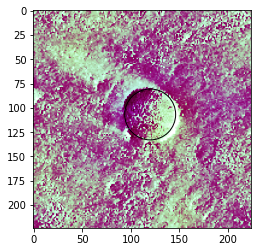

In [8]:
to_view = 9
X, Y = next(train_gen)
img = X[to_view]
target = Y[to_view]

def pred_to_px(vec):
    xc, yc, R = vec[0], vec[1], vec[2]
    xc = (xc*12) + 112
    yc = (yc*12) + 112
    R = R*112
    return xc, yc, R

fig, ax = plt.subplots()
ax.imshow(img)
x, y, r = target
circle = plt.Circle((y, x), r, fill=False)
ax.add_artist(circle)
plt.show()

In [4]:
from keras.models import load_model
model = load_model('./models/simple_circle.h5')

In [5]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import SGD
from focal_loss import focal_loss

#model = load_model('./models/sigmoid.h5')
callbacks = []
callbacks.append(ModelCheckpoint('./models/simple_circle2.h5', save_best_only=True, monitor='val_loss', verbose=True))

model.compile(
    #optimizer = SGD(lr=1e-5, decay=1e-6, momentum=.5),
    #optimizer=Adam(lr=1e-5, beta_1=0.5, decay=1e-5),
    optimizer='adam',
    #optimizer=SGD(),
    #loss=focal_loss(alpha=.25, gamma=2),
    #metrics=['binary_crossentropy'],
    loss='mse'
)

val_steps = len(val)//val_batch_size
steps = len(train)//train_batch_size
history = model.fit_generator(
    train_gen,
    steps_per_epoch=steps,
    epochs=10,
    validation_data = val_gen,
    validation_steps = val_steps,
    verbose=True,
    callbacks=callbacks
)

Epoch 1/10
180/420 [===========>..................] - ETA: 22:28 - loss: 110.3100

KeyboardInterrupt: 

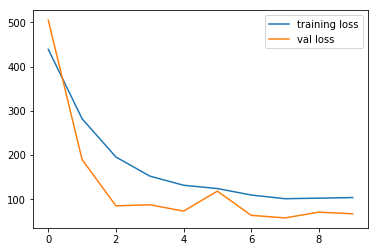

In [10]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [ ]:
history2 = model.fit_generator(
    train_gen,
    steps_per_epoch=steps,
    epochs=20,
    validation_data = val_gen,
    validation_steps = val_steps,
    verbose=True,
    callbacks=callbacks
)

Epoch 1/20
420/420 [==============================] - 2701s 6s/step - loss: 97.9135 - val_loss: 124.8340

Epoch 00001: val_loss did not improve from 58.10687
Epoch 2/20
420/420 [==============================] - 2702s 6s/step - loss: 94.9676 - val_loss: 146.8708

Epoch 00002: val_loss did not improve from 58.10687
Epoch 3/20
420/420 [==============================] - 2700s 6s/step - loss: 92.4062 - val_loss: 76.1771

Epoch 00003: val_loss did not improve from 58.10687
Epoch 4/20
420/420 [==============================] - 2703s 6s/step - loss: 91.0586 - val_loss: 93.3614

Epoch 00004: val_loss did not improve from 58.10687
Epoch 5/20
420/420 [==============================] - 2702s 6s/step - loss: 88.7214 - val_loss: 84.4890

Epoch 00005: val_loss did not improve from 58.10687
Epoch 6/20
420/420 [==============================] - 2708s 6s/step - loss: 88.8360 - val_loss: 67.5144

Epoch 00006: val_loss did not improve from 58.10687
Epoch 7/20
420/420 [==============================] - 27

In [ ]:
plt.plot(history2.history['loss'], label='training loss')
plt.plot(history2.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [13]:
model.save('models/circles_overfit.h5')

In [16]:
del model
model = load_model('models/circles_overfit.h5')

for layer in model.layers:
    layer.trainable=True
    
callbacks = []
callbacks.append(ModelCheckpoint('./models/circle_out_finetune.h5', save_best_only=True, monitor='val_loss', verbose=True))
    

model.compile(
    #optimizer = SGD(lr=1e-5, decay=1e-6),
    #optimizer=Adam(lr=1e-5, beta_1=0.5, decay=1e-5),
    optimizer='adam',
    #optimizer=SGD(),
    #loss=focal_loss(alpha=.25, gamma=2),
    #metrics=['binary_crossentropy'],
    loss='mse'
)
    
history3 = model.fit_generator(
    train_gen,
    steps_per_epoch=steps,
    epochs=10,
    validation_data = val_gen,
    validation_steps = val_steps,
    verbose=True,
    callbacks=callbacks
)

Epoch 1/10
420/420 [==============================] - 253s 604ms/step - loss: 0.0506 - val_loss: 0.0641

Epoch 00001: val_loss improved from inf to 0.06410, saving model to ./models/circle_out_finetune.h5
Epoch 2/10
420/420 [==============================] - 246s 587ms/step - loss: 0.0475 - val_loss: 0.0767

Epoch 00002: val_loss did not improve from 0.06410
Epoch 3/10
420/420 [==============================] - 245s 584ms/step - loss: 0.0467 - val_loss: 0.0920

Epoch 00003: val_loss did not improve from 0.06410
Epoch 4/10
420/420 [==============================] - 247s 589ms/step - loss: 0.0451 - val_loss: 0.0503

Epoch 00004: val_loss improved from 0.06410 to 0.05028, saving model to ./models/circle_out_finetune.h5
Epoch 5/10
420/420 [==============================] - 246s 586ms/step - loss: 0.0447 - val_loss: 0.0569

Epoch 00005: val_loss did not improve from 0.05028
Epoch 6/10
420/420 [==============================] - 246s 586ms/step - loss: 0.0443 - val_loss: 0.0544

Epoch 00006: 

KeyboardInterrupt: 

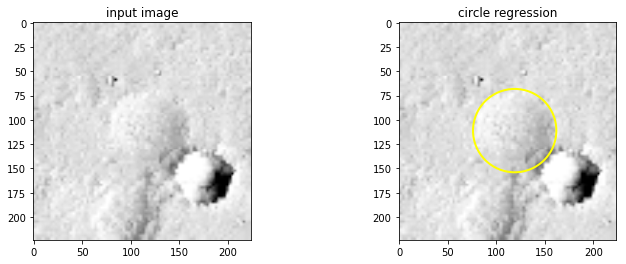

In [61]:
#test_gen = datagen(val, val=False, batch_size=256)

def pred_to_px(vec):
    xc, yc, R = vec[0], vec[1], vec[2]
    xc = (xc*12) + 112
    yc = (yc*12) + 112
    R = R*112
    return xc, yc, R

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

#X, Y = next(test_gen)
#Y_pred = model.predict(X)
see = 1
img = X[see, :, :, 0]
gt = Y[see]
xc, yc, R = pred_to_px(gt)
circle1 = plt.Circle((yc, xc), R, color='r', fill=False, lw=2)

pred = Y_pred[see]
xc, yc, R = pred_to_px(pred)
circle2 = plt.Circle((yc, xc), R, color='yellow', fill=False, lw=2)

ax[0].imshow(img, cmap='Greys_r')
ax[0].set_title('input image')
ax[1].imshow(img, cmap='Greys_r')
#ax[1].add_artist(circle1)
ax[1].add_artist(circle2)
ax[1].set_title('circle regression')
plt.show();


In [ ]:
"""bloats mcgee"""
import tensorflow as tf
from keras.layers import Input, BatchNormalization, Conv2D, Conv2DTranspose, Dense
from keras.layers import MaxPooling2D, Concatenate, Reshape, AveragePooling2D
from keras.models import Model

def build_feature_model(weightpath='./models/thin_overfit.h5'):
    w = 8
    dim = 224
    weights = load_model(weightpath).get_weights()
    def conv_layer(n, w, weights=None):
        """Standard 3x3 conv layer used in model."""
        if weights is None:
            return Conv2D(filters=n*w, kernel_size=(3,3), padding='same', activation='relu')
        else:
            return Conv2D(filters=n*w, kernel_size=(3,3), padding='same', activation='relu', weights=weights)
    
    def deconv_layer(n, w, weights=None):
        """Standard 'deconvolution' layer used in model."""
        if weights is None:
            return Conv2DTranspose(filters=n*w, kernel_size=(2, 2), strides=2, activation='relu')
        else:
            return Conv2DTranspose(filters=n*w, kernel_size=(2, 2), strides=2, activation='relu', weights=weights)
    
    inp = Input((224, 224, 3))
    x = BatchNormalization(weights=weights[0:4])(inp)
    x = conv_layer(2, w, weights=weights[4:6])(x)
    x = conv_layer(4, w, weights=weights[6:8])(x)
    mid1 = BatchNormalization(weights=weights[8:12])(x)
    x = Conv2D(filters=32, kernel_size=3, activation='relu', strides=2, name='newconv1')(mid1)
    x = Conv2D(filters=16, kernel_size=3, activation='relu', strides=2, name='newconv2')(x)
    x = Conv2D(filters=8, kernel_size=3, activation='relu', strides=2, name='newconv3')(x)
    out1 = Conv2D(filters=4, kernel_size=3, activation='relu', strides=2, name='newconv4')(x)
    x = MaxPooling2D()(mid1)
    x = conv_layer(4, w, weights=weights[12:14])(x)
    x = conv_layer(8, w, weights=weights[14:16])(x)
    mid2 = BatchNormalization(weights=weights[16:20])(x)
    x = Conv2D(filters=64, kernel_size=3, activation='relu', strides=2, name='newconv5')(mid2)
    x = Conv2D(filters=32, kernel_size=3, activation='relu', strides=2, name='newconv6')(x)
    x = Conv2D(filters=16, kernel_size=3, activation='relu', strides=2, name='newconv7')(x)
    out2 = Conv2D(filters=8, kernel_size=3, activation='relu', strides=2, name='newconv8')(x)
    x = MaxPooling2D()(mid2)
    x = conv_layer(8, w, weights=weights[20:22])(x)
    x = conv_layer(16, w, weights=weights[22:24])(x)
    mid3 = BatchNormalization(weights=weights[24:28])(x)
    x = Conv2D(filters=128, kernel_size=3, activation='relu', strides=1, name='newconv9')(mid3)
    x = Conv2D(filters=64, kernel_size=3, activation='relu', strides=2, name='newconv10')(x)
    x = Conv2D(filters=32, kernel_size=3, activation='relu', strides=2, name='newconv11')(x)
    out3 = Conv2D(filters=16, kernel_size=3, activation='relu', strides=2, name='newconv12')(x)
    x = MaxPooling2D()(mid3)
    x = conv_layer(16, w, weights=weights[28:30])(x)
    x = conv_layer(32, w, weights=weights[30:32])(x)
    x = conv_layer(32, w, weights=weights[32:34])(x)
    mid4 = BatchNormalization(weights=weights[34:38])(x)
    x = Conv2D(filters=256, kernel_size=3, activation='relu', strides=2, name='newconv13')(mid4)
    x = Conv2D(filters=128, kernel_size=3, activation='relu', strides=2, name='newconv14')(x)
    out4 = Conv2D(filters=64, kernel_size=4, activation='relu', strides=1, name='newconv15')(x)
    x = MaxPooling2D()(mid4)
    x = conv_layer(32, w, weights=weights[38:40])(x)
    x = conv_layer(64, w, weights=weights[40:42])(x)
    mid5 = conv_layer(64, w, weights=weights[42:44])(x)
    x = Conv2D(filters=512, kernel_size=3, activation='relu', name='newconv16')(mid5)
    x = Conv2D(filters=256, kernel_size=3, activation='relu', name='newconv17')(x)
    x = Conv2D(filters=128, kernel_size=3, activation='relu', name='newconv18')(x)
    x = Conv2D(filters=64, kernel_size=3, activation='relu', name='newconv19')(x)
    out5 = Conv2D(filters=32, kernel_size=3, activation='relu', name='newconv20')(x)
    x = Conv2D(filters=128*w, kernel_size=(1,1), padding='same', activation='relu', weights=weights[44:46])(mid5)
    x = AveragePooling2D(pool_size=(dim//16,dim//16))(x)
    x = Reshape((-1,))(x)
    x = Dense(128*w, activation='relu', weights=weights[46:48])(x)
    
    out6 = Dense(64*w, activation='relu', weights=weights[48:50])(x)
    outs = [out1, out2, out3, out4, out5, out6]
    for i, out in enumerate(outs):
        outs[i] = Reshape((-1,))(out)
    x = Concatenate()(outs)
    x = Dense(512, activation='relu', name='newdense1')(x)
    x = Dense(512, activation='relu', name='newdense2')(x)
    output = Dense(3, name='newdense3')(x)
    
    model = Model(inputs=inp, outputs=output)
    for layer in model.layers:
        if 'new' in layer.name:
            layer.trainable=True
        else:
            layer.trainable=False
    return model
    
model = build_feature_model()
model.summary()